## PERSON DETECTION USING PRETRAINED MODEL (MobileNetV2)

### Importing the all necessary libraries

In [1]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

### Paths to dataset

In [2]:
dataset_dir = 'human detection dataset'
classes = ['1', '0']

### Create directories for train, validation, and test sets


In [3]:
base_dir = 'base_directory'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

### Splitting  the data by making a split_data function


In [4]:
def split_data(src_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.2, 0.1)):
    for cls in classes:
        cls_dir = os.path.join(src_dir, cls)
        images = os.listdir(cls_dir)
        train_files, val_test_files = train_test_split(images, test_size=1-split_ratio[0], random_state=42)
        val_files, test_files = train_test_split(val_test_files, test_size=split_ratio[2]/(split_ratio[1]+split_ratio[2]), random_state=42)
        
        for file in train_files:
            shutil.copy(os.path.join(cls_dir, file), os.path.join(train_dir, cls, file))
        
        for file in val_files:
            shutil.copy(os.path.join(cls_dir, file), os.path.join(val_dir, cls, file))
        
        for file in test_files:
            shutil.copy(os.path.join(cls_dir, file), os.path.join(test_dir, cls, file))

# Calling the function
split_data(dataset_dir, train_dir, validation_dir, test_dir)

### Image data generators for data augmentation


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 644 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


### Printing 5 images of each class from the training dataset


#### Class 0:  No Person --------  Class 1: Person

Class: 0


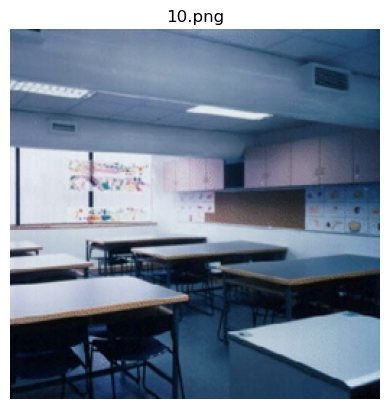

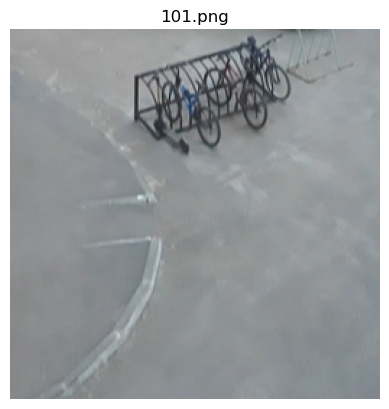

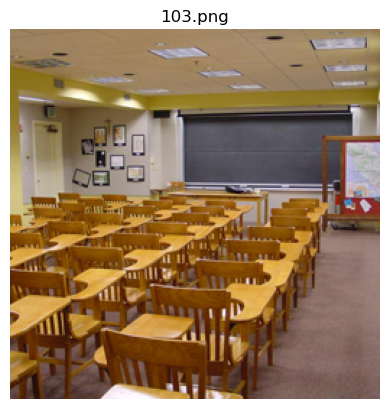

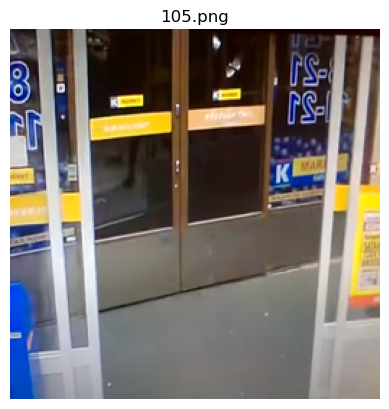

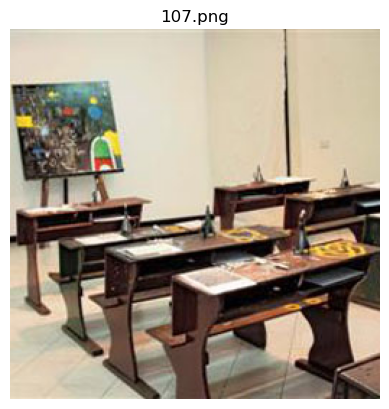

Class: 1


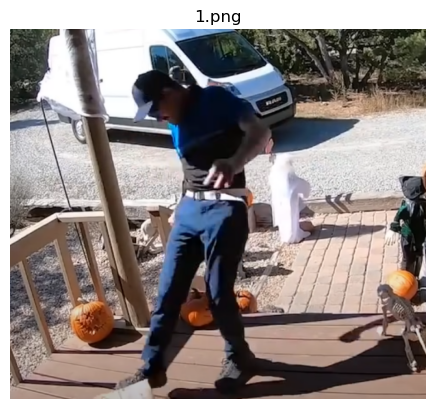

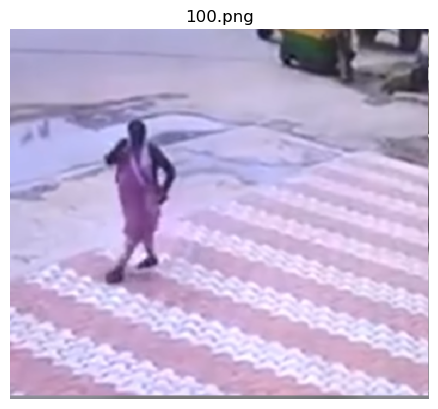

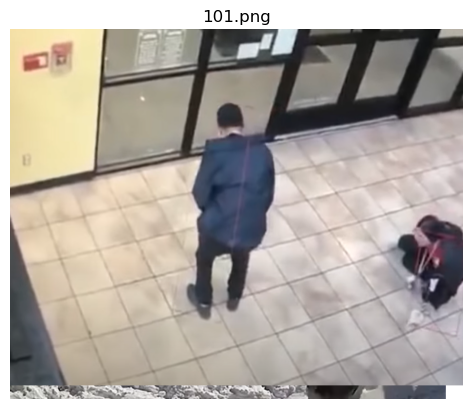

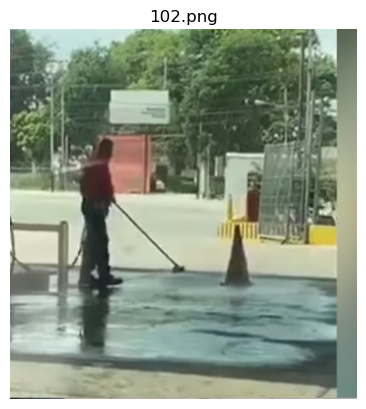

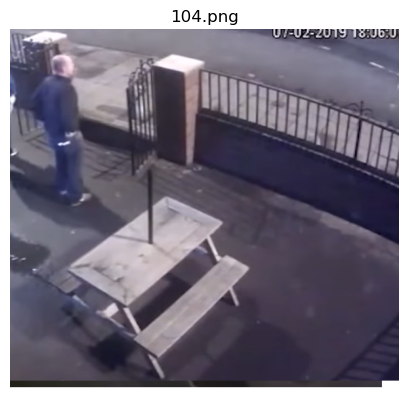

In [6]:
import matplotlib.pyplot as plt
import os
import imghdr  # Module to check image file type

# Function to print 5 images of each class from the training dataset
def print_images(train_generator, num_images=5):
    class_names = list(train_generator.class_indices.keys())
    for class_name in class_names:
        print(f"Class: {class_name}")
        class_index = train_generator.class_indices[class_name]
        class_dir = os.path.join(train_generator.directory, class_name)
        class_images = [img for img in os.listdir(class_dir) if imghdr.what(os.path.join(class_dir, img)) == 'png'][:num_images]
        for image_name in class_images:
            image_path = os.path.join(class_dir, image_name)
            try:
                img = plt.imread(image_path)
                plt.imshow(img)
                plt.title(image_name)
                plt.axis('off')
                plt.show()
            except SyntaxError:
                print(f"Skipping non-PNG file: {image_path}")

# Print 5 images of each class from the training dataset
print_images(train_generator)


### Build the model using pretrained MobileNetV2


In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.65),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(80, activation='relu'),
    Dropout(0.65),
    Dense(1, activation='sigmoid')
])

### Compile the model

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


### Train the model


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)


Epoch 1/20
20/20 [==============================] - 62s 3s/step - loss: 0.9070 - accuracy: 0.5245 - val_loss: 0.6657 - val_accuracy: 0.5500
Epoch 2/20
20/20 [==============================] - 51s 3s/step - loss: 0.8180 - accuracy: 0.5768 - val_loss: 0.6158 - val_accuracy: 0.5562
Epoch 3/20
20/20 [==============================] - 52s 3s/step - loss: 0.6821 - accuracy: 0.6095 - val_loss: 0.5646 - val_accuracy: 0.6187
Epoch 4/20
20/20 [==============================] - 54s 3s/step - loss: 0.6851 - accuracy: 0.6013 - val_loss: 0.5418 - val_accuracy: 0.6687
Epoch 5/20
20/20 [==============================] - 56s 3s/step - loss: 0.5741 - accuracy: 0.6797 - val_loss: 0.4938 - val_accuracy: 0.7312
Epoch 6/20
20/20 [==============================] - 54s 3s/step - loss: 0.5109 - accuracy: 0.7288 - val_loss: 0.4519 - val_accuracy: 0.7750
Epoch 7/20
20/20 [==============================] - 55s 3s/step - loss: 0.4266 - accuracy: 0.8072 - val_loss: 0.4308 - val_accuracy: 0.7937
Epoch 8/20
20/20 [==

### Plot train and validation loss and accuracy over epochs


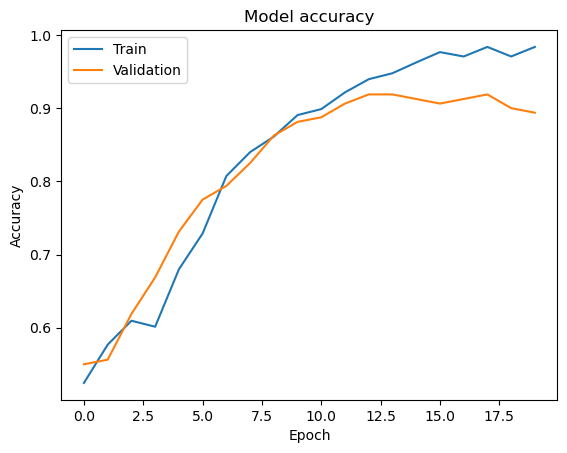

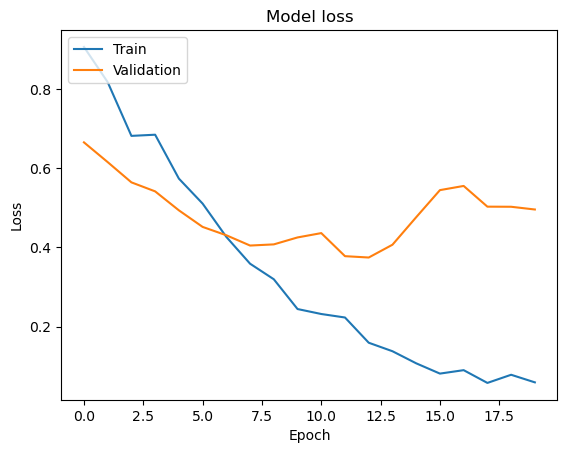

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)


### Evaluate the model on validation set


In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

6/6 [==============================] - 4s 595ms/step - loss: 0.4352 - accuracy: 0.9022
Validation Accuracy: 90.22%


### Predict on the validation set


In [11]:

validation_generator.reset()
val_predictions = model.predict(validation_generator)
val_predicted_labels = (val_predictions > 0.5).astype(int).ravel()

6/6 [==============================] - 4s 585ms/step


### Get the true labels for validation set


In [12]:
val_true_labels = validation_generator.classes

### Compute the confusion matrix & classification report for validation set


In [13]:

val_conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
print("Validation Confusion Matrix:")
print(val_conf_matrix)

val_class_report = classification_report(val_true_labels, val_predicted_labels, target_names=validation_generator.class_indices.keys())
print("Validation Classification Report:")
print(val_class_report)

Validation Confusion Matrix:
[[ 58  14]
 [  4 108]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        72
           1       0.89      0.96      0.92       112

    accuracy                           0.90       184
   macro avg       0.91      0.88      0.89       184
weighted avg       0.90      0.90      0.90       184



### Evaluating, predcting, and getting true Labels for the model on test set


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on the test set
test_generator.reset()
test_predictions = model.predict(test_generator)
test_predicted_labels = (test_predictions > 0.5).astype(int).ravel()

# Get the true labels for test set
test_true_labels = test_generator.classes

3/3 [==============================] - 2s 605ms/step - loss: 0.2657 - accuracy: 0.9570
Test Accuracy: 95.70%
3/3 [==============================] - 2s 641ms/step


### Compute the confusion matrix & classification report for test set


In [15]:

test_conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
print("Test Confusion Matrix:")
print(test_conf_matrix)

test_class_report = classification_report(test_true_labels, test_predicted_labels, target_names=test_generator.class_indices.keys())
print("Test Classification Report:")
print(test_class_report)


Test Confusion Matrix:
[[34  3]
 [ 1 55]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.95      0.98      0.96        56

    accuracy                           0.96        93
   macro avg       0.96      0.95      0.95        93
weighted avg       0.96      0.96      0.96        93



### Saving the model


In [16]:
model.save('person_detection_model.h5')

### Loading the saved Model & Checking it's performance on some images collected from the internet

1/1 [==============================] - 1s 677ms/step


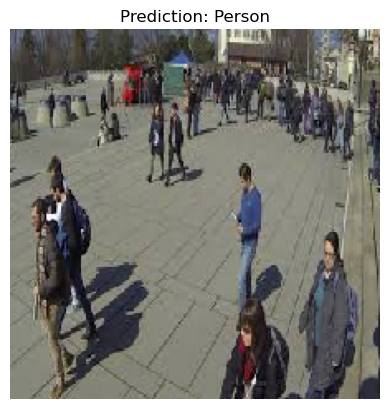

The prediction for img1.jpeg is: Person
1/1 [==============================] - 0s 56ms/step


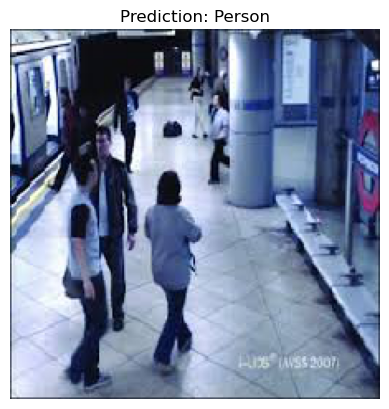

The prediction for img2.jpeg is: Person
1/1 [==============================] - 0s 56ms/step


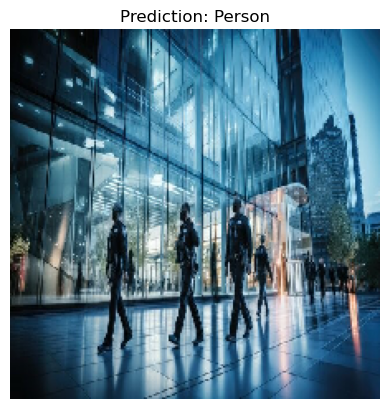

The prediction for img3.jpeg is: Person
1/1 [==============================] - 0s 48ms/step


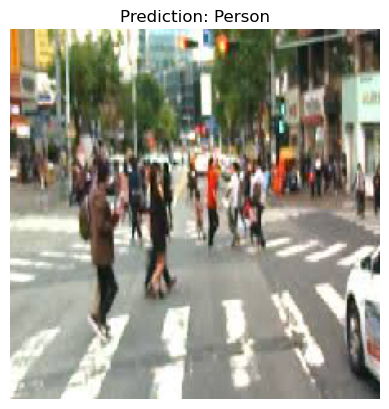

The prediction for img4.jpeg is: Person
1/1 [==============================] - 0s 65ms/step


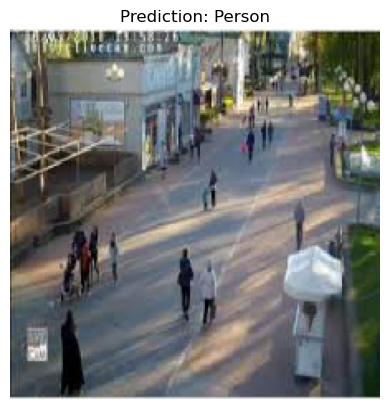

The prediction for img5.jpeg is: Person
1/1 [==============================] - 0s 59ms/step


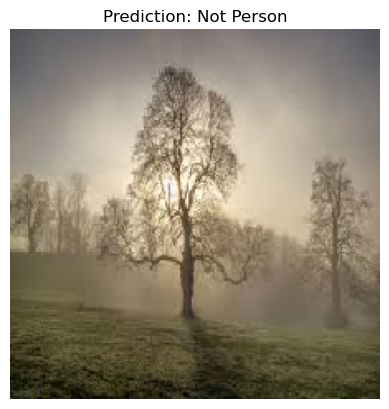

The prediction for img6.jpeg is: Not Person
1/1 [==============================] - 0s 60ms/step


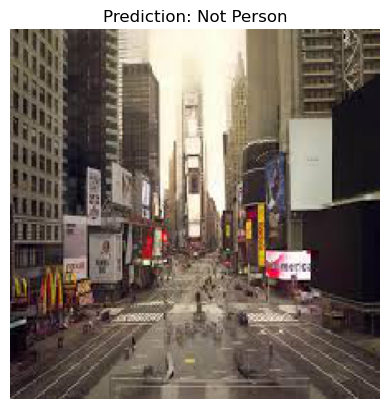

The prediction for img7.jpeg is: Not Person
1/1 [==============================] - 0s 55ms/step


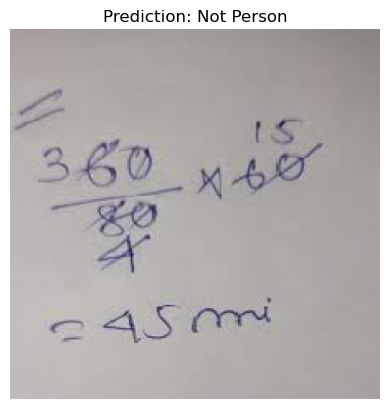

The prediction for img8.jpeg is: Not Person
1/1 [==============================] - 0s 64ms/step


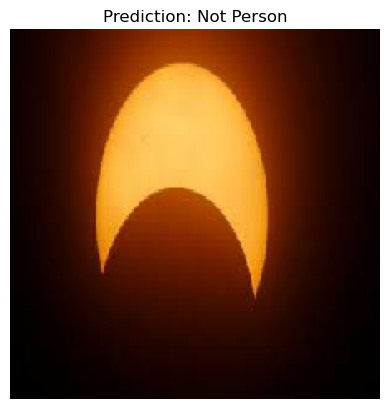

The prediction for img9.jpeg is: Not Person
1/1 [==============================] - 0s 61ms/step


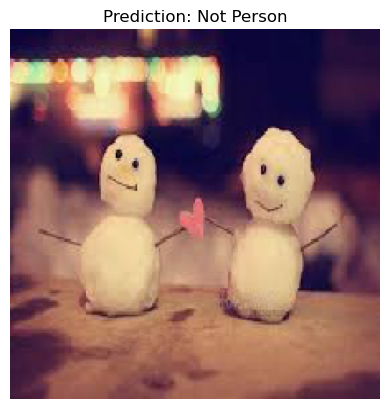

The prediction for img10.jpeg is: Not Person


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('person_detection_model.h5')

def predict_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_label = 'Person' if prediction[0][0] > 0.5 else 'Not Person'
    
    # Display the image
    plt.imshow(img)
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')
    plt.show()
    
    return predicted_label

# Example usage
image_dir = r"C:\Users\sifta\Desktop\Person Detection\Testing Images"
image_files = [f"img{i}.jpeg" for i in range(1, 11)]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    prediction = predict_image(image_path)
    print(f'The prediction for {image_file} is: {prediction}')


## Thank You, I hope you like it